In [10]:
import pyupbit
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
mpl.rcParams['font.family'] = 'AppleGothic'   # Mac 기본 한글 폰트
mpl.rcParams['axes.unicode_minus'] = False    # 음수(-) 깨짐 방지

## 알트코인 하나 흔들봇

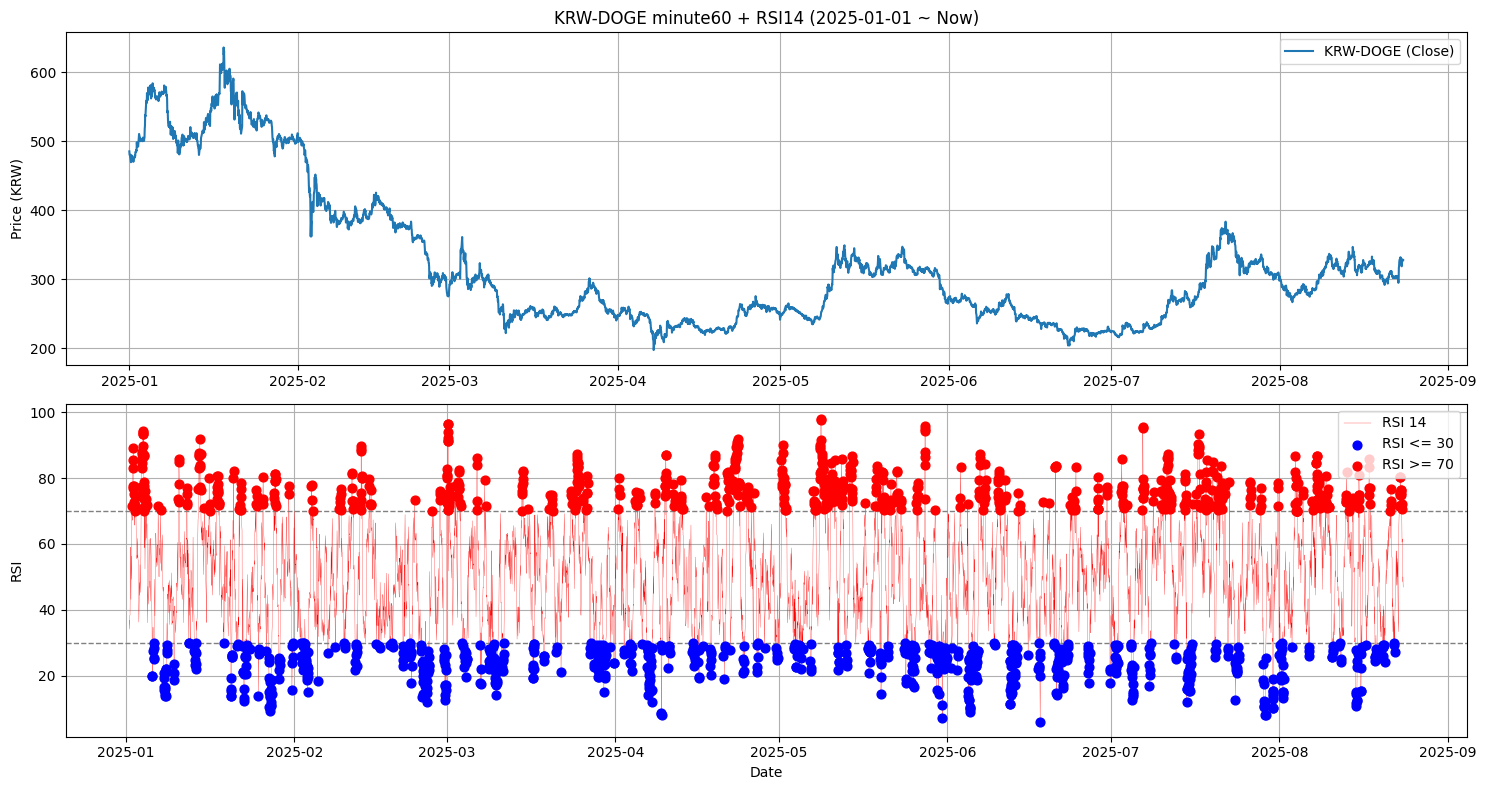


📌 [시뮬레이션 전략 요약]
- 봇 실행 주기: 15분마다 실행 (즉, 같은 봉에서 4번 기회 발생 가정)
- 매수: RSI ≤ 30 → 남은 현금의 20%씩 분할 매수 (단, 최소 5,000원 이상만 매수, 수수료 0.05% 반영)
- 매도: RSI ≥ 70 구간에서
       · 손실/본전 → 전량 매도
       · 수익률 ≥ 25% → 보유 물량 절반 매도 (단, 최소 5,000원 이상일 때만)
- 그 외 구간은 보유 유지

📌 시뮬레이션 실행 환경
 - 종목: KRW-DOGE
 - 시작일: 2025-01-01
 - 차트 간격: minute60
 - 봇 실행 주기: 15분마다 실행 가정
 - 초기 자본: 1,000,000 원
 - 수수료율: 0.05%
 - 최소 거래 단위: 5,000 원

📌 시뮬레이션 실행 주기
 - 캔들 주기: 60분 (1시간)
 - 봇 주기: 15분
 - 따라서 한 봉이 완성되기 전까지 조건 확인 기회: 4번
📊 과매도 구간 개수 (RSI <= 30): 776
📊 과매수 구간 개수 (RSI >= 70): 755
2025-01-05 21:00:00 매수: 563원 | 매수 금액: 200000원 | 평균 단가: 563원 | 잔여 현금: 800000원
2025-01-05 22:00:00 매수: 560원 | 매수 금액: 160000원 | 평균 단가: 562원 | 잔여 현금: 640000원
2025-01-05 23:00:00 매수: 562원 | 매수 금액: 128000원 | 평균 단가: 562원 | 잔여 현금: 512000원
2025-01-06 03:00:00 매수: 563원 | 매수 금액: 102400원 | 평균 단가: 562원 | 잔여 현금: 409600원
2025-01-06 04:00:00 매수: 562원 | 매수 금액: 81920원 | 평균 단가: 562원 | 잔여 현금: 327680원
2025-01-06 05:00:00 매수: 561원 | 매수 금액: 65536원 | 평균 단가: 562원 | 잔여 현금: 262144원
202

In [ ]:
# ======================
# 🔹 설정값 (여기만 수정해서 재사용 가능)
ticker = "KRW-BTC"          # 마켓 (예: KRW-ETH, KRW-XRP 등)
start_date = "2025-01-01"   # 데이터 조회 시작일
interval = "minute240"      # 캔들 간격 ("minute60"=1시간, "minute240"=4시간, "day"=일봉 등)
bot_interval = 30          # 봇 실행 주기 (분 단위: 예 30=30분마다, 240=4시간마다)

start_date = "2025-08-01"   # 데이터 조회 시작일
ticker = "KRW-DOGE"          # 마켓 (예: KRW-ETH, KRW-XRP 등)
interval = "minute60"      # 캔들 간격 ("minute60"=1시간, "minute240"=4시간, "day"=일봉 등)
bot_interval = 15          # 봇 실행 주기 (분 단위: 예 30=30분마다, 240=4시간마다)
fee = 0.0005                # 업비트 시장가 수수료 0.05%
initial_capital = 1_000_000 # 초기 자본 100만원
min_trade = 5000            # 업비트 최소 주문 단위 5천원
# ======================


# 1️⃣ OHLCV 데이터 수집 (200개씩 반복 요청)
all_data = []
to = datetime.now()

while True:
    data = pyupbit.get_ohlcv(ticker, interval=interval, to=to, count=200)
    if data is None or data.empty:
        break
    all_data.append(data)
    to = data.index[0]  # 다음 요청의 끝 시점을 갱신
    if to < pd.to_datetime(start_date):
        break

# 전체 데이터를 합치고 시작일 이후만 필터링
df = pd.concat(all_data)
df = df[df.index >= pd.to_datetime(start_date)]
df.sort_index(inplace=True)

# 2️⃣ RSI 14 계산
delta = df["close"].diff()               # 종가 변화량
gain = np.where(delta > 0, delta, 0)     # 상승분
loss = np.where(delta < 0, -delta, 0)    # 하락분

roll_up = pd.Series(gain).rolling(window=14).mean()
roll_down = pd.Series(loss).rolling(window=14).mean()

RS = roll_up / roll_down
RSI = 100.0 - (100.0 / (1.0 + RS))
df["RSI14"] = RSI.values

# 3️⃣ RSI 차트 시각화
plt.figure(figsize=(15,8))

# (a) 가격 차트
plt.subplot(2,1,1)
plt.plot(df.index, df["close"], label=f"{ticker} (Close)")
plt.title(f"{ticker} {interval} + RSI14 ({start_date} ~ Now)")
plt.ylabel("Price (KRW)")
plt.legend()
plt.grid(True)

# (b) RSI 차트
plt.subplot(2,1,2)
plt.plot(df.index, df["RSI14"], color="red", label="RSI 14", linewidth=0.2)
plt.axhline(70, color="gray", linestyle="--", linewidth=1)  # 과매수 기준선
plt.axhline(30, color="gray", linestyle="--", linewidth=1)  # 과매도 기준선

# RSI 조건별 구간 표시
oversold = df[df["RSI14"] <= 30]   # RSI 30 이하 (과매도)
overbought = df[df["RSI14"] >= 70] # RSI 70 이상 (과매수)

plt.scatter(oversold.index, oversold["RSI14"], color="blue", s=40, zorder=5, label="RSI <= 30")
plt.scatter(overbought.index, overbought["RSI14"], color="red", s=40, zorder=5, label="RSI >= 70")

plt.ylabel("RSI")
plt.xlabel("Date")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
# ======================
print("\n" + "="*50)
print("📌 [시뮬레이션 전략 요약]")
print(f"- 봇 실행 주기: {bot_interval}분마다 실행 (즉, 같은 봉에서 {int(int(interval.replace('minute','')) / bot_interval)}번 기회 발생 가정)")
print("- 매수: RSI ≤ 30 → 남은 현금의 20%씩 분할 매수 (단, 최소 5,000원 이상만 매수, 수수료 0.05% 반영)")
print("- 매도: RSI ≥ 70 구간에서")
print("       · 손실/본전 → 전량 매도")
print("       · 수익률 ≥ 25% → 보유 물량 절반 매도 (단, 최소 5,000원 이상일 때만)")
print("- 그 외 구간은 보유 유지")

# 🔹 현재 설정 출력
print("\n===============================")
print("📌 시뮬레이션 실행 환경")
print(f" - 종목: {ticker}")
print(f" - 시작일: {start_date}")
print(f" - 차트 간격: {interval}")
print(f" - 봇 실행 주기: {bot_interval}분마다 실행 가정")
print(f" - 초기 자본: {initial_capital:,} 원")
print(f" - 수수료율: {fee*100:.2f}%")
print(f" - 최소 거래 단위: {min_trade:,} 원")

print("\n===============================")
print("📌 시뮬레이션 실행 주기")
candle_minutes = int(interval.replace("minute", "")) if "minute" in interval else None
if candle_minutes and bot_interval:
    checks_per_candle = candle_minutes // bot_interval
    print(f" - 캔들 주기: {candle_minutes}분 ({candle_minutes//60}시간)")
    print(f" - 봇 주기: {bot_interval}분")
    print(f" - 따라서 한 봉이 완성되기 전까지 조건 확인 기회: {checks_per_candle}번")
print("===============================")

# RSI 구간 개수 카운트 출력
print(f"📊 과매도 구간 개수 (RSI <= 30): {len(oversold)}")
print(f"📊 과매수 구간 개수 (RSI >= 70): {len(overbought)}")

# ======================
# 4️⃣ 매매 시뮬레이션
capital = initial_capital  # 현금 보유액
position = 0               # 코인 보유량
avg_buy_price = 0          # 평균 매수가 (분할 매수 반영)

for i in range(len(df)):
    rsi = df["RSI14"].iloc[i]    # i번째 봉의 RSI
    price = df["close"].iloc[i]  # i번째 봉의 종가

    # ✅ 매수 조건: RSI 30 이하 → 남은 현금의 20% 매수 (최소 5000원 이상일 때만)
    if rsi <= 30 and capital > 0:
        invest_amount = capital * 0.2

        if invest_amount < min_trade:  # 최소 매수 금액 미만이면 스킵
            continue

        btc_amount = (invest_amount * (1 - fee)) / price  # 수수료 반영
        total_cost = (avg_buy_price * position) + invest_amount
        position += btc_amount
        avg_buy_price = total_cost / position             # 가중 평균 매수가
        capital -= invest_amount
        print(f"{df.index[i]} 매수: {price:.0f}원 | 매수 금액: {invest_amount:.0f}원 | 평균 단가: {avg_buy_price:.0f}원 | 잔여 현금: {capital:.0f}원")

    # ✅ 매도 조건: RSI 70 이상 → 손실이면 전량, 25% 이상 수익이면 절반 매도 (단, 최소 5000원 이상일 때만)
    elif rsi >= 70 and position > 0:
        profit_rate = (price - avg_buy_price) / avg_buy_price * 100
        hold_value = position * price  # 현재 보유 코인의 평가 금액

        if hold_value < min_trade:  # 최소 매도 금액 미만이면 스킵
            continue

        if profit_rate <= 0:
            # 손실 → 전량 매도
            sell_value = hold_value * (1 - fee)
            capital += sell_value
            print(f"{df.index[i]} 전량 매도(손실/본전): {price:.0f}원 | 매도 금액: {sell_value:,.0f}원 | 수익률: {profit_rate:.2f}%")
            position = 0
            avg_buy_price = 0

        elif profit_rate >= 25:
            # 수익률 25% 이상 → 절반 매도
            sell_amount = position / 2
            sell_value = (sell_amount * price) * (1 - fee)

            if sell_value < min_trade:  # 절반 매도 금액이 5000원 미만이면 스킵
                continue

            capital += sell_value
            position -= sell_amount
            print(f"{df.index[i]} 절반 매도(익절): {price:.0f}원 | 매도 금액: {sell_value:,.0f}원 | 남은 {ticker}: {position:.6f} | 수익률: {profit_rate:.2f}%")

# 5️⃣ 시뮬레이션 종료 후 최종 정산
final_value = capital + (position * df["close"].iloc[-1])
profit_rate = (final_value - initial_capital) / initial_capital * 100

print("="*50)
print(f"💰 최종 평가 금액: {final_value:,.0f} 원")
print(f"📈 총 수익률: {profit_rate:.2f}%")
print("="*50)


## 다중 자동매매

In [4]:
import pyupbit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ======================
# 🔹 설정값
tickers = ["KRW-BTC", "KRW-ETH", "KRW-XRP", "KRW-ADA", "KRW-SOL"]  # 5개 코인
start_date = "2025-01-01"
interval = "minute60"      # 4시간봉
bot_interval = 30           # 30분마다 실행
fee = 0.0005                # 업비트 수수료 0.05%
initial_capital = 1_000_000 # 코인별 초기자본 100만원
min_trade = 5000            # 최소 거래단위
# ======================

def get_rsi_dataframe(ticker, start_date, interval):
    """코인 데이터 + RSI14 계산"""
    all_data = []
    to = datetime.now()
    while True:
        data = pyupbit.get_ohlcv(ticker, interval=interval, to=to, count=200)
        if data is None or data.empty:
            break
        all_data.append(data)
        to = data.index[0]
        if to < pd.to_datetime(start_date):
            break

    df = pd.concat(all_data)
    df = df[df.index >= pd.to_datetime(start_date)]
    df.sort_index(inplace=True)

    delta = df["close"].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    roll_up = pd.Series(gain).rolling(window=14).mean()
    roll_down = pd.Series(loss).rolling(window=14).mean()
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    df["RSI14"] = RSI.values
    return df

def simulate_trading(ticker, df):
    """RSI 기반 매매 시뮬레이션"""
    capital = initial_capital
    position = 0
    avg_buy_price = 0

    for i in range(len(df)):
        rsi = df["RSI14"].iloc[i]
        price = df["close"].iloc[i]

        # 매수 조건
        if rsi <= 30 and capital > 0:
            invest_amount = capital * 0.2
            if invest_amount < min_trade:
                continue
            btc_amount = (invest_amount * (1 - fee)) / price
            total_cost = (avg_buy_price * position) + invest_amount
            position += btc_amount
            avg_buy_price = total_cost / position
            capital -= invest_amount

        # 매도 조건
        elif rsi >= 70 and position > 0:
            profit_rate = (price - avg_buy_price) / avg_buy_price * 100
            hold_value = position * price
            if hold_value < min_trade:
                continue

            if profit_rate <= 0:  # 손실 → 전량 매도
                sell_value = hold_value * (1 - fee)
                capital += sell_value
                position = 0
                avg_buy_price = 0
            elif profit_rate >= 25:  # 수익률 25% 이상 → 절반 매도
                sell_amount = position / 2
                sell_value = (sell_amount * price) * (1 - fee)
                if sell_value < min_trade:
                    continue
                capital += sell_value
                position -= sell_amount

    final_value = capital + (position * df["close"].iloc[-1])
    profit_rate = (final_value - initial_capital) / initial_capital * 100
    return final_value, profit_rate

# ======================
# 🔹 실행
results = {}
total_value = 0

for ticker in tickers:
    df = get_rsi_dataframe(ticker, start_date, interval)
    final_value, profit_rate = simulate_trading(ticker, df)
    results[ticker] = (final_value, profit_rate)
    total_value += final_value

# ======================
# 🔹 결과 출력
print("="*50)
print("📌 [다중 코인 자동매매 시뮬레이션 결과]")
for t, (val, pr) in results.items():
    print(f" - {t}: 최종 평가금액 {val:,.0f} 원 | 수익률 {pr:.2f}%")
print("-"*50)
print(f"💰 총합 (5개 코인): {total_value:,.0f} 원")
print("="*50)


📌 [다중 코인 자동매매 시뮬레이션 결과]
 - KRW-BTC: 최종 평가금액 1,154,013 원 | 수익률 15.40%
 - KRW-ETH: 최종 평가금액 817,648 원 | 수익률 -18.24%
 - KRW-XRP: 최종 평가금액 1,602,787 원 | 수익률 60.28%
 - KRW-ADA: 최종 평가금액 1,535,141 원 | 수익률 53.51%
 - KRW-SOL: 최종 평가금액 996,333 원 | 수익률 -0.37%
--------------------------------------------------
💰 총합 (5개 코인): 6,105,922 원


## 다중 자동매매 개선중

In [ ]:
# # [made by index]
# import pyupbit
# import pandas as pd
# import numpy as np
# from datetime import datetime

# # ======================
# # 🔹 설정값
# tickers = ["KRW-BTC", "KRW-ETH", "KRW-XRP", "KRW-ADA", "KRW-SOL"]
# start_date = "2025-01-01"
# interval = "minute60"
# bot_interval = 15
# fee = 0.0005
# initial_capital = 1_000_000
# min_trade = 5000
# # ======================

# def get_rsi_dataframe(ticker, start_date, interval):
#     all_data = []
#     to = datetime.now()
#     while True:
#         df = pyupbit.get_ohlcv(ticker, interval=interval, to=to, count=200)
#         if df is None or df.empty:
#             break
#         all_data.append(df)
#         to = df.index[0]
#         if to < pd.to_datetime(start_date):
#             break

#     df = pd.concat(all_data)
#     df = df[df.index >= pd.to_datetime(start_date)]
#     df.sort_index(inplace=True)

#     delta = df["close"].diff()
#     gain = np.where(delta > 0, delta, 0)
#     loss = np.where(delta < 0, -delta, 0)
#     roll_up = pd.Series(gain).rolling(window=14).mean()
#     roll_down = pd.Series(loss).rolling(window=14).mean()
#     RS = roll_up / roll_down
#     RSI = 100.0 - (100.0 / (1.0 + RS))
#     df["RSI14"] = RSI.values
#     return df

# # ======================
# # 🔹 데이터 수집
# print("⏳ 데이터 수집 중...")

# dfs = []
# for t in tickers:
#     df = get_rsi_dataframe(t, start_date, interval)
#     df["ticker"] = t
#     dfs.append(df)

# df_all = pd.concat(dfs).sort_index()

# # ======================
# # 🔹 시뮬레이션 실행
# capital = initial_capital
# positions = {t: {"amount": 0, "avg_buy": 0, "invested": 0} for t in tickers}
# realized_pnl = {t: 0 for t in tickers}  # 💡 실현 손익 추가

# for time, group in df_all.groupby(df_all.index):
#     for _, row in group.iterrows():
#         ticker = row["ticker"]
#         price = row["close"]
#         rsi = row["RSI14"]

#         # ✅ 매수 조건
#         if rsi <= 30 and capital > 0:
#             invest_amount = capital * 0.2
#             if invest_amount < min_trade:
#                 continue
#             amount = (invest_amount * (1 - fee)) / price
#             total_cost = positions[ticker]["avg_buy"] * positions[ticker]["amount"] + invest_amount
#             positions[ticker]["amount"] += amount
#             positions[ticker]["invested"] += invest_amount
#             positions[ticker]["avg_buy"] = total_cost / positions[ticker]["amount"]
#             capital -= invest_amount

#         # ✅ 매도 조건
#         elif rsi >= 70 and positions[ticker]["amount"] > 0:
#             hold_value = positions[ticker]["amount"] * price
#             if hold_value < min_trade:
#                 continue

#             avg_buy = positions[ticker]["avg_buy"]
#             profit_rate = (price - avg_buy) / avg_buy * 100

#             if profit_rate <= 0:  # 전량 손절
#                 sell_value = hold_value * (1 - fee)
#                 realized_pnl[ticker] += sell_value - positions[ticker]["invested"]
#                 capital += sell_value
#                 positions[ticker] = {"amount": 0, "avg_buy": 0, "invested": 0}

#             elif profit_rate >= 25:  # 절반 익절
#                 sell_amount = positions[ticker]["amount"] / 2
#                 sell_value = (sell_amount * price) * (1 - fee)
#                 if sell_value < min_trade:
#                     continue
#                 realized_pnl[ticker] += sell_value - (positions[ticker]["invested"] / 2)
#                 capital += sell_value
#                 positions[ticker]["amount"] -= sell_amount
#                 positions[ticker]["invested"] *= 0.5

# # ======================
# # 🔹 최종 평가
# final_value = capital
# coin_results = {}

# for t in tickers:
#     df = dfs[tickers.index(t)]
#     last_price = df["close"].iloc[-1]
#     hold_value = positions[t]["amount"] * last_price
#     invested = positions[t]["invested"]
#     realized = realized_pnl[t]

#     final_value += hold_value

#     # 실현손익 + 현재 보유 평가손익
#     total_invested = invested + max(-realized, 0)  # 손실이었으면 투자금액으로 간주
#     total_profit = realized + (hold_value - invested)

#     if total_invested > 0:
#         profit_rate = total_profit / total_invested * 100
#         coin_results[t] = (hold_value + realized, total_invested, profit_rate)
#     else:
#         coin_results[t] = (0, 0, None)

# total_profit_rate = (final_value - initial_capital) / initial_capital * 100

# # ======================
# # 🔹 결과 출력
# print("="*60)
# print("📌 [다중 코인 공유자본 시뮬레이션 결과]")
# print(f" - 총 초기 자본: {initial_capital:,.0f} 원")
# print(f" - 최종 평가금액: {final_value:,.0f} 원")
# print(f" - 총 수익률: {total_profit_rate:.2f}%")
# print("-"*60)
# print("📊 코인별 결과:")

# for t, (val, invested, pr) in coin_results.items():
#     if pr is None:
#         print(f" - {t}: 거래 없음")
#     else:
#         print(f" - {t}: 투자금 {invested:,.0f} 원 → 평가금액 {val:,.0f} 원 | 수익률 {pr:.2f}%")

# print("="*60)


⏳ 데이터 수집 중...
📌 [다중 코인 공유자본 시뮬레이션 결과]
 - 총 초기 자본: 1,000,000 원
 - 최종 평가금액: 1,018,668 원
 - 총 수익률: 1.87%
------------------------------------------------------------
📊 코인별 결과:
 - KRW-BTC: 투자금 802,452 원 → 평가금액 868,333 원 | 수익률 8.75%
 - KRW-ETH: 투자금 21,206 원 → 평가금액 -10,804 원 | 수익률 -70.37%
 - KRW-XRP: 투자금 15,744 원 → 평가금액 -15,744 원 | 수익률 -100.00%
 - KRW-ADA: 투자금 139,945 원 → 평가금액 -130,221 원 | 수익률 -96.13%
 - KRW-SOL: 투자금 4,181 원 → 평가금액 117,847 원 | 수익률 2718.67%


## 실제 코드 백테스팅